In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.optim import Optimizer
from torch.optim import lr_scheduler

import numpy as np
import time
import matplotlib.pyplot as plt

In [2]:
# Load CIFAR-10 dataset.
transform = transforms.Compose([
    transforms.Resize(36),
    transforms.RandomCrop(32),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Set hyperparameters.
batch_size = 100
num_epoches = 50
lr = 0.005


trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(dataset=trainset, batch_size=batch_size, 
                                          shuffle=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(dataset=testset, batch_size=batch_size,
                                         shuffle=False)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
step_rate = len(trainloader) /  batch_size

print("Current batch size: {}".format(batch_size))
print("Current learning rate: {}".format(lr))
print("Current total epoch: {}".format(num_epoches))
print("Current device: {}".format(device))
print("Current step rate: {}".format(step_rate))

Files already downloaded and verified
Files already downloaded and verified
Current batch size: 100
Current learning rate: 0.005
Current total epoch: 50
Current device: cuda:0
Current step rate: 5.0


In [3]:
from PIL import Image

for idx, (images, target) in enumerate(trainloader):
    print("Image[{}] train size: {}".format(idx, images.shape))
    
    if (idx == 3):
        break
        
for idx, (images, target) in enumerate(testloader):
    print("Image[{}] test size: {}".format(idx, images.shape))
    
    if (idx == 3):
        break

Image[0] train size: torch.Size([100, 3, 32, 32])
Image[1] train size: torch.Size([100, 3, 32, 32])
Image[2] train size: torch.Size([100, 3, 32, 32])
Image[3] train size: torch.Size([100, 3, 32, 32])
Image[0] test size: torch.Size([100, 3, 32, 32])
Image[1] test size: torch.Size([100, 3, 32, 32])
Image[2] test size: torch.Size([100, 3, 32, 32])
Image[3] test size: torch.Size([100, 3, 32, 32])


In [4]:
# This module define the training model of PAL optimizer.

def PAL_loss_func(model, images, target, backward=True):
    loss_fn = nn.CrossEntropyLoss()
    output = model(images)
    loss = loss_fn(output, target)
    if (backward):
        loss.backward()
    return loss, output

def PAL_train_model(model, num_epochs, optimizer, device, 
    trainloader, decay_rate=0.999, decay_step=450):
    loss_func = nn.CrossEntropyLoss()
    loss_func.to(device)
    model.to(device)
    
    losses = []
    accs = []
    
    for epoch in range(num_epochs):
        # loss = train(model, trainloader, loss_func, optimizer, device, epoch)
        
        loss = 0.0
        for idx, (images, target) in enumerate(trainloader):
            images = images.to(device)
            target = target.to(device)
            output = model(images)

            # Forward
            optimizer.zero_grad()
            loss_item = loss_func(output, target)

            #------------------------ Decay Update -----------------------#
            mss_tmp = 0.0
            mas_tmp = 0.0

            for param_group in optimizer.param_groups:
                mss_tmp = param_group['mss']
                mas_tmp = param_group['max_ss']

            decay_factor = decay_rate ** (((epoch + 1) * step_rate + idx) / decay_step)
            mss_new = mss_tmp * decay_factor
            mas_new = mas_tmp * decay_factor

            for param_group in optimizer.param_groups:
                param_group['mss'] = mss_new
                param_group['mas'] = mas_new
            #------------------------ Decay Update -----------------------#

            optimizer.step(PAL_loss_func, model, images, target)
            loss += loss_item.item()

        loss = loss / len(trainloader)
        accuracy = PAL_evaluate_model(model, testloader, device)

        print("Epoch [{}] Loss: {:.4f}".format(epoch, loss))
        print("Epoch [{}] Accuracy: {:.4f}".format(epoch, accuracy))
        losses.append(loss)
        accs.append(accuracy)

    return accs, losses

def PAL_evaluate_model(model, validloader, device):
    model.eval()

    with torch.no_grad():
        correct = 0.0
        total = 0

        for idx, (images, target) in enumerate(validloader):
            images = images.to(device)
            target = target.to(device)
            output = model(images)

            _, pred = torch.max(output.data, dim=1)
            correct += (pred == target).sum().item()
            total += target.size(0)
        accuracy = correct / total
    return accuracy

In [5]:
class PAL(Optimizer):
    r"""Implements PAL algorithm.
    
    It has been proposed in PAL: 'A fast DNN optimization method based on curvature information'_.
    
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        mss (float, optional): maximum step size, to hinder the algorithm from failing
            due to inaccurate parabolic approximations.(default: 0.1, recommand [0.1, 0.01])
        mmt (float, optional): momentum. Refine g_t = alpha * g_{t-1} + dL(x, theta)
            (default: 0.4, recommand: [0, 0.6])
        lat (float, optional): loose approximation, a parameter lambda is added 
            to the calculation of the second derivative. When lambda in [0, 1], the
            curvature of theparabola is reduced. If lambda in [1, inf], increased.
            (default: 0.6, recommand: [0.4,0.6])
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
            
    .. _PAL\: PAL: A fast DNN optimization method based on curvature information
        https://arxiv.org/abs/1903.11991
    """
    
    def __init__(self, params, mss=0.9, mmt=0.4, lat=0.6, max_ss=3.0, eps=1e-8):
        
        if not (0.0 <= mss):
            raise ValueError("Invalid measuring step size: {}".format(mss))
        if not (0.0 <= mmt):
            raise ValueError("Invalid momentum: {}".format(mmt))
        if not (0.0 <= lat):
            raise ValueError("Invalid loose approximation factor: {}".format(lat))
        if not (0.0 <= max_ss):
            raise ValueError("Invalid maximum step size: {}".format(max_ss))
        if not (0.0 <= eps):
            raise ValueError("Invalid epsilon value: {}".format(eps))
        defaults = dict(mss=mss, mmt=mmt, lat=lat, max_ss=max_ss, eps=eps)
        self.t_step = -1
        super(PAL, self).__init__(params, defaults)
        
    def get_norm_derv(self, params, mmt, eps):
        norm = torch.tensor(0.0)
        derivative = torch.tensor(0.0)
        with torch.no_grad():
            for p in params:
                if p.grad is None:
                    continue
                flat_grad = p.grad.data.view(-1)
                norm += torch.dot(flat_grad, flat_grad)
            norm = torch.sqrt(norm)
            if (norm == 0):
                norm = eps
            derivative = -norm
        return norm, derivative
        
    def update(self, params, step, grad_norm):
        if (step != 0):
            for p in params:
                if p.grad is None:
                    continue
                p.data.add_(step * -p.grad.data / grad_norm)
    
    def step(self, loss_func, model, images, target):
        self.t_step += 1
        for group in self.param_groups:
            params = group['params']
            max_ss = group['max_ss']
            mss = group['mss']
            mmt = group['mmt']
            lat = group['lat']
            eps = group['eps']
            
            loss_0, *returns = loss_func(model, images, target, backward=True)
            grad_norm, loss_d0 = self.get_norm_derv(params, mmt, eps)
            
            # Update with length mss.
            self.update(params, mss, grad_norm)
            loss_mss, *_ = loss_func(model, images, target, backward=False)
            
            # Derivative
            loss_d1 = (loss_mss - loss_0) / mss;
            loss_d2 = lat * (loss_d1 - loss_d0) / (mss / 2)
            
            # Avoid Nan.
            if (torch.isnan(loss_d2) or torch.isnan(loss_d1) or torch.isnan(loss_d0)):
                return [loss_0] + returns
            
            # Case discrimination.
            if (loss_d2 > 0 and loss_d0 < 0):
                sup = -(loss_d0 / loss_d2)
            elif (loss_d2 <= 0 and loss_d0 < 0):
                sup = torch.tensor(mss)
            else:
                sup = torch.tensor(0.0)
                
            if (sup > max_ss):
                sup = torch.tensor(max_ss)
            sup -= mss
            
            self.update(params, sup, grad_norm)
            return [loss_0] + returns

In [6]:
# This module define the resnet.

# 3x3 convolution
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3,
                    stride=stride, padding=1, bias=False)

# Block
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(Block, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        
    def forward(self, x):
        residual = x
        if self.downsample is not None:
            residual = self.downsample(x)
            
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        out = self.relu(out)
        return out

class ResNet34(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet34, self).__init__()
        self.in_channels = 64
        self.conv = conv3x3(3, 64)
        self.bn = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 64,  num_blocks=layers[0], stride=1)
        self.layer2 = self.make_layer(block, 128, num_blocks=layers[1], stride=2)
        self.layer3 = self.make_layer(block, 256, num_blocks=layers[2], stride=2)
        self.layer4 = self.make_layer(block, 512, num_blocks=layers[3], stride=2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(512, num_classes)
        
    def make_layer(self, block, out_channels, num_blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
            
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, num_blocks):
            layers.append(block(out_channels, out_channels))
            
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [7]:
# This module is revised throught the training code from the DL class.

def optim_train_model(model, num_epochs, optimizer, device, trainloader):
    loss_func = nn.CrossEntropyLoss()
    
    model.to(device)
    loss_func.to(device)
    
    losses = []
    accs = []
    
    for epoch in range(num_epochs):
        loss = 0.0
        for idx, (images, target) in enumerate(trainloader):
            #schedule.step()
            
            images = images.to(device)
            target = target.to(device)
            output = model(images)

            _loss = loss_func(output, target)
            optimizer.zero_grad()
            _loss.backward()
            optimizer.step()

            loss += _loss
        
        loss = loss / len(trainloader)
        accuracy = optim_evaluate_model(model, testloader, device)
        print("Epoch [{}] Loss: {:.4f}".format(epoch, loss))
        print("Epoch [{}] Accuracy: {:.4f}".format(epoch, accuracy))          
        
        losses.append(loss)
        accs.append(accuracy)
        
    return accs, losses

def optim_evaluate_model(model, validloader, device):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        
        for i, (images, targets) in enumerate(validloader):
            # device: cpu or gpu
            images = images.to(device)
            targets = targets.to(device)
            
            
            outputs = model(images)
            _, pred = torch.max(outputs.data, dim=1)
                      
            correct += (pred == targets).sum().item()
            total += targets.size(0)
            
        accuracy = correct / total
        return accuracy

In [8]:
print("Start to run resnet with PAL optimizer")
start = time.time()
model = ResNet34(Block, [2, 2, 2, 2])
optimizer = PAL(model.parameters())
accs_PAL, losses_PAL = PAL_train_model(model, num_epoches, optimizer, device, trainloader)
end = time.time()
print("Program run time: {:.2f}s".format(end-start))

Start to run resnet with PAL optimizer
Epoch [0] Loss: 1.8723
Epoch [0] Accuracy: 0.4423
Epoch [1] Loss: 1.2894
Epoch [1] Accuracy: 0.5443
Epoch [2] Loss: 1.1219
Epoch [2] Accuracy: 0.6158
Epoch [3] Loss: 0.9533
Epoch [3] Accuracy: 0.6571
Epoch [4] Loss: 0.8107
Epoch [4] Accuracy: 0.7500
Epoch [5] Loss: 0.6982
Epoch [5] Accuracy: 0.6960
Epoch [6] Loss: 0.6064
Epoch [6] Accuracy: 0.7818
Epoch [7] Loss: 0.5268
Epoch [7] Accuracy: 0.7670
Epoch [8] Loss: 0.4555
Epoch [8] Accuracy: 0.8046
Epoch [9] Loss: 0.3902
Epoch [9] Accuracy: 0.8184
Epoch [10] Loss: 0.3307
Epoch [10] Accuracy: 0.8280
Epoch [11] Loss: 0.2738
Epoch [11] Accuracy: 0.8371
Epoch [12] Loss: 0.2233
Epoch [12] Accuracy: 0.8432
Epoch [13] Loss: 0.1814
Epoch [13] Accuracy: 0.8465
Epoch [14] Loss: 0.1421
Epoch [14] Accuracy: 0.8464
Epoch [15] Loss: 0.1167
Epoch [15] Accuracy: 0.8467
Epoch [16] Loss: 0.0943
Epoch [16] Accuracy: 0.8523
Epoch [17] Loss: 0.0836
Epoch [17] Accuracy: 0.8427
Epoch [18] Loss: 0.0817
Epoch [18] Accuracy: 

In [9]:
print("Start to run resnet with Adam optimizer")
start = time.time()
model = ResNet34(Block, [2, 2, 2, 2])
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
accs_Adam, losses_Adam = optim_train_model(model, num_epoches, optimizer, device, trainloader)
end = time.time()
print("Program run time: {:.2f}s".format(end-start))

Start to run resnet with Adam optimizer
Epoch [0] Loss: 1.2804
Epoch [0] Accuracy: 0.6237
Epoch [1] Loss: 0.9633
Epoch [1] Accuracy: 0.7026
Epoch [2] Loss: 0.7552
Epoch [2] Accuracy: 0.7429
Epoch [3] Loss: 0.6436
Epoch [3] Accuracy: 0.7678
Epoch [4] Loss: 0.5518
Epoch [4] Accuracy: 0.7950
Epoch [5] Loss: 0.4818
Epoch [5] Accuracy: 0.7965
Epoch [6] Loss: 0.4286
Epoch [6] Accuracy: 0.8083
Epoch [7] Loss: 0.3712
Epoch [7] Accuracy: 0.8250
Epoch [8] Loss: 0.3233
Epoch [8] Accuracy: 0.8192
Epoch [9] Loss: 0.2808
Epoch [9] Accuracy: 0.8241
Epoch [10] Loss: 0.2451
Epoch [10] Accuracy: 0.8113
Epoch [11] Loss: 0.2191
Epoch [11] Accuracy: 0.8349
Epoch [12] Loss: 0.1891
Epoch [12] Accuracy: 0.8403
Epoch [13] Loss: 0.1740
Epoch [13] Accuracy: 0.8405
Epoch [14] Loss: 0.1567
Epoch [14] Accuracy: 0.8376
Epoch [15] Loss: 0.1439
Epoch [15] Accuracy: 0.8441
Epoch [16] Loss: 0.1289
Epoch [16] Accuracy: 0.8347
Epoch [17] Loss: 0.1153
Epoch [17] Accuracy: 0.8368
Epoch [18] Loss: 0.1092
Epoch [18] Accuracy:

In [10]:
print("Start to run resnet with SGD optimizer")
start = time.time()
model = ResNet34(Block, [2, 2, 2, 2])
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
accs_SGD, losses_SGD = optim_train_model(model, num_epoches, optimizer, device, trainloader)
end = time.time()
print("Program run time: {:.2f}s".format(end-start))

Start to run resnet with SGD optimizer
Epoch [0] Loss: 1.9874
Epoch [0] Accuracy: 0.3693
Epoch [1] Loss: 1.5935
Epoch [1] Accuracy: 0.4469
Epoch [2] Loss: 1.4398
Epoch [2] Accuracy: 0.5051
Epoch [3] Loss: 1.3379
Epoch [3] Accuracy: 0.5245
Epoch [4] Loss: 1.2530
Epoch [4] Accuracy: 0.5558
Epoch [5] Loss: 1.1588
Epoch [5] Accuracy: 0.5823
Epoch [6] Loss: 1.0903
Epoch [6] Accuracy: 0.6032
Epoch [7] Loss: 1.0182
Epoch [7] Accuracy: 0.6402
Epoch [8] Loss: 0.9629
Epoch [8] Accuracy: 0.6537
Epoch [9] Loss: 0.9118
Epoch [9] Accuracy: 0.6725
Epoch [10] Loss: 0.8690
Epoch [10] Accuracy: 0.6893
Epoch [11] Loss: 0.8265
Epoch [11] Accuracy: 0.6694
Epoch [12] Loss: 0.7942
Epoch [12] Accuracy: 0.6945
Epoch [13] Loss: 0.7562
Epoch [13] Accuracy: 0.7099
Epoch [14] Loss: 0.7271
Epoch [14] Accuracy: 0.7230
Epoch [15] Loss: 0.6984
Epoch [15] Accuracy: 0.7318
Epoch [16] Loss: 0.6717
Epoch [16] Accuracy: 0.7226
Epoch [17] Loss: 0.6446
Epoch [17] Accuracy: 0.7292
Epoch [18] Loss: 0.6118
Epoch [18] Accuracy: 

In [11]:
print("Start to run resnet with RMSprop optimizer")
start = time.time()
model = ResNet34(Block, [2, 2, 2, 2])
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.0001, alpha=0.9)
accs_RMS, losses_RMS = optim_train_model(model, num_epoches, optimizer, device, trainloader)
end = time.time()
print("Program run time: {:.2f}s".format(end-start))

Start to run resnet with RMSprop optimizer
Epoch [0] Loss: 1.2901
Epoch [0] Accuracy: 0.6243
Epoch [1] Loss: 1.2100
Epoch [1] Accuracy: 0.6673
Epoch [2] Loss: 0.8811
Epoch [2] Accuracy: 0.7267
Epoch [3] Loss: 0.7329
Epoch [3] Accuracy: 0.7410
Epoch [4] Loss: 0.6241
Epoch [4] Accuracy: 0.7298
Epoch [5] Loss: 0.5468
Epoch [5] Accuracy: 0.7960
Epoch [6] Loss: 0.4677
Epoch [6] Accuracy: 0.8098
Epoch [7] Loss: 0.4150
Epoch [7] Accuracy: 0.8020
Epoch [8] Loss: 0.3641
Epoch [8] Accuracy: 0.8221
Epoch [9] Loss: 0.3212
Epoch [9] Accuracy: 0.8222
Epoch [10] Loss: 0.2867
Epoch [10] Accuracy: 0.8346
Epoch [11] Loss: 0.2551
Epoch [11] Accuracy: 0.8204
Epoch [12] Loss: 0.2294
Epoch [12] Accuracy: 0.8319
Epoch [13] Loss: 0.2091
Epoch [13] Accuracy: 0.8391
Epoch [14] Loss: 0.1896
Epoch [14] Accuracy: 0.8325
Epoch [15] Loss: 0.1705
Epoch [15] Accuracy: 0.8420
Epoch [16] Loss: 0.1572
Epoch [16] Accuracy: 0.8325
Epoch [17] Loss: 0.1480
Epoch [17] Accuracy: 0.8490
Epoch [18] Loss: 0.1343
Epoch [18] Accura

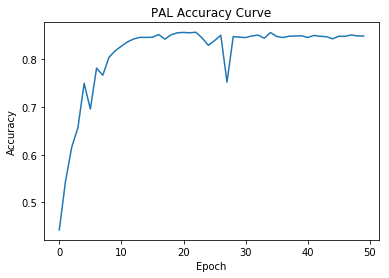

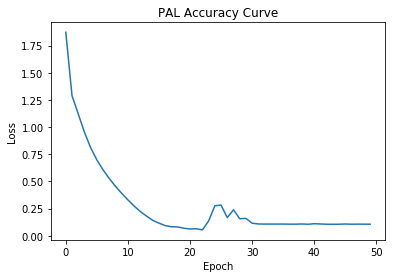

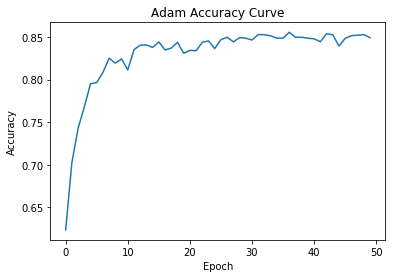

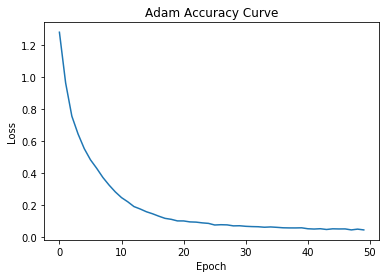

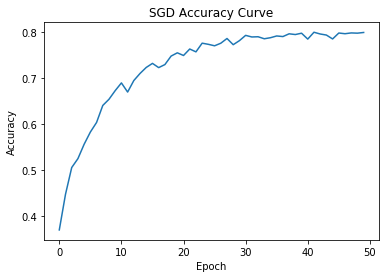

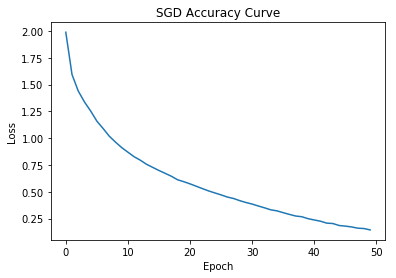

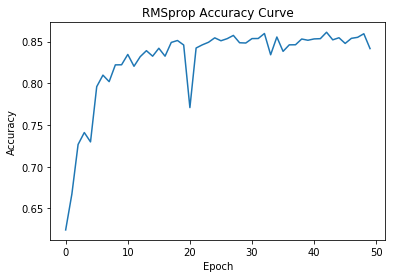

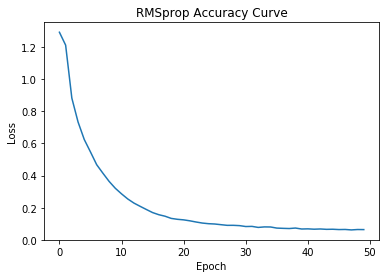

In [29]:
def create_curve(result, title, xlabel, ylabel, Type="Accuracy"):
    x_data = np.array(range(len(result)))
    y_data = np.array(result)
    plt.plot(x_data, y_data)
    plt.title("{} Accuracy Curve".format(title))
    plt.xlabel("{}".format(xlabel))
    plt.ylabel("{}".format(ylabel))
    if (Type == "Accuracy"):
        plt.savefig("{}_accuracy.png".format(title))
    elif(Type == "Loss"):
        plt.savefig("{}_loss.png".format(title))
    plt.show()
    
create_curve(accs_PAL, "PAL", "Epoch", "Accuracy", Type="Accuracy")
create_curve(losses_PAL, "PAL", "Epoch", "Loss", Type="Loss")
create_curve(accs_Adam, "Adam", "Epoch", "Accuracy", Type="Accuracy")
create_curve(losses_Adam, "Adam", "Epoch", "Loss", Type="Loss")
create_curve(accs_SGD, "SGD", "Epoch", "Accuracy", Type="Accuracy")
create_curve(losses_SGD, "SGD", "Epoch", "Loss", Type="Loss")
create_curve(accs_RMS, "RMSprop", "Epoch", "Accuracy", Type="Accuracy")
create_curve(losses_RMS, "RMSprop", "Epoch", "Loss", Type="Loss")

In [15]:
losses = [losses_PAL, losses_Adam, losses_SGD, losses_RMS]
accuracy = [accs_PAL, accs_Adam, accs_SGD, accs_RMS]

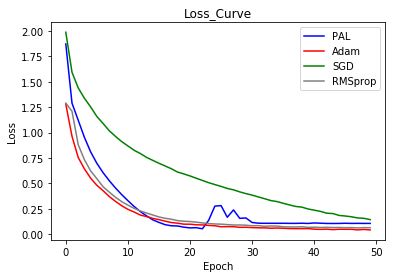

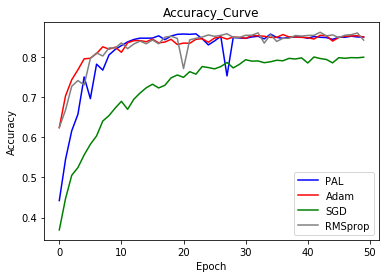

In [27]:
def make_curve(losses, accuracy):
    curve_name = ["PAL", "Adam", "SGD", "RMSprop"]
    color = ['b', 'r', 'g', 'gray']
    plt.figure(1)
    for idx in range(len(losses)):
        x_data = np.array(range(len(losses[idx])))
        y_data = np.array(losses[idx])
        plt.plot(x_data, y_data, c=color[idx], label=curve_name[idx])
        plt.title("Loss_Curve")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
    plt.axis()
    plt.legend()
    plt.savefig("Loss.png")
    plt.show()
    
    plt.figure(2)
    for idx in range(len(accuracy)):
        x_data = np.array(range(len(accuracy[idx])))
        y_data = np.array(accuracy[idx])
        plt.plot(x_data, y_data, c=color[idx], label=curve_name[idx])
        plt.title("Accuracy_Curve")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
    plt.axis()
    plt.legend()
    plt.savefig("Accuracy.png")
    plt.show()
    
make_curve(losses, accuracy)